In [1]:
# Neural network for multi regression
from numpy import loadtxt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import ceil, pi
import random
from random import sample
from sklearn.model_selection import RepeatedKFold
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import h5py # For model saving: https://machinelearningmastery.com/save-load-keras-deep-learning-models/


In [2]:
tf.keras.backend.clear_session()


In [4]:
train = pd.read_csv('train.csv')
validation = pd.read_csv('validation.csv')


train['C0_norm'] = (train.C0*-1 - min(train.C0*-1))/(max(train.C0*-1) - min(train.C0*-1))
#test['C0_norm'] = (test.C0*-1 - min(train.C0*-1))/(max(train.C0*-1) - min(train.C0*-1))
validation['C0_norm'] = (validation.C0*-1 - min(train.C0*-1))/(max(train.C0*-1) - min(train.C0*-1))

train['lam_norm'] = (train.lam_dim - min(train.lam_dim))/(max(train.lam_dim) - min(train.lam_dim))
#test['lam_norm'] = (test.lam_dim - min(train.lam_dim))/(max(train.lam_dim) - min(train.lam_dim))
validation['lam_norm'] = (validation.lam_dim - min(train.lam_dim))/(max(train.lam_dim) - min(train.lam_dim))

train['delta_norm'] = (train.delta - min(train.delta))/(max(train.delta) - min(train.delta))
#test['delta_norm'] = (test.delta - min(train.delta))/(max(train.delta) - min(train.delta))
validation['delta_norm'] = (validation.delta - min(train.delta))/(max(train.delta) - min(train.delta))

train['rad_norm'] = (train.rad - min(train.rad))/(max(train.rad) - min(train.rad))
validation['rad_norm'] = (validation.rad - min(train.rad))/(max(train.rad) - min(train.rad))



In [5]:
features = ['C0_norm', 'rad_norm', 'delta_norm', 'lam_norm']

train_x = train[features].to_numpy() 
train_y = train.iloc[:, -104:-4].to_numpy()

validation_x = validation[features].to_numpy()
validation_y = validation.iloc[:, -104:-4].to_numpy()

n_inputs = train_x.shape[1]
n_outputs = train_y.shape[1]

In [6]:
def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(20,  activation='relu'))
    model.add(Dense(100, activation='relu'))
    keras.layers.Dropout(0.25)
    model.add(Dense(100, activation='relu'))
    keras.layers.Dropout(0.25)
    model.add(Dense(100, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(n_outputs))
    #model.compile(loss='mae', optimizer='adam')
    opt = tf.keras.optimizers.Adam(learning_rate=0.001) # Setting the learning rate very low should allow more exploration before minimizing to a local minimum
    model.compile(loss='mae', optimizer=opt, metrics=['mae'])
    return model

In [7]:
# Tutorial on callbacks: https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

es = EarlyStopping(
    monitor='mae', 
    verbose=1,
    patience=200,
    mode='min',
    restore_best_weights=True)

mc = ModelCheckpoint(
    'best_model_regression_dk.h5', 
    monitor='mae', 
    mode='min', 
    verbose=1,
    patience=200,
    save_best_only=True)


In [8]:
n_inputs, n_outputs = train_x.shape[1], train_y.shape[1]
model = get_model(n_inputs, n_outputs)
model.fit(train_x, train_y, verbose=0, epochs=4000, batch_size=64, callbacks=[es, mc])
        


Epoch 00001: mae improved from inf to 149.25804, saving model to best_model_regression_dk.h5

Epoch 00002: mae improved from 149.25804 to 10.79849, saving model to best_model_regression_dk.h5

Epoch 00003: mae improved from 10.79849 to 9.08686, saving model to best_model_regression_dk.h5

Epoch 00004: mae improved from 9.08686 to 8.37918, saving model to best_model_regression_dk.h5

Epoch 00005: mae improved from 8.37918 to 7.92722, saving model to best_model_regression_dk.h5

Epoch 00006: mae improved from 7.92722 to 7.65894, saving model to best_model_regression_dk.h5

Epoch 00007: mae improved from 7.65894 to 7.50589, saving model to best_model_regression_dk.h5

Epoch 00008: mae did not improve from 7.50589

Epoch 00009: mae improved from 7.50589 to 7.46984, saving model to best_model_regression_dk.h5

Epoch 00010: mae did not improve from 7.46984

Epoch 00011: mae improved from 7.46984 to 7.39604, saving model to best_model_regression_dk.h5

Epoch 00012: mae improved from 7.39604 

In [9]:
model = load_model('best_model_regression_dk.h5')

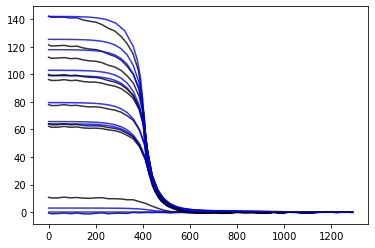

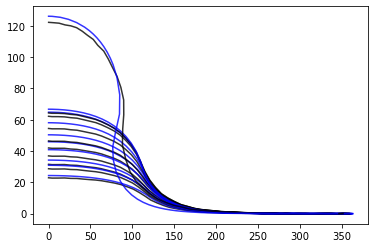

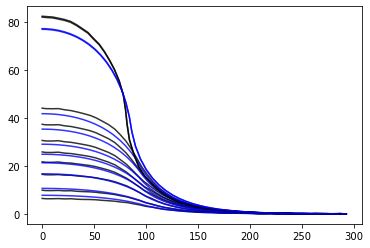

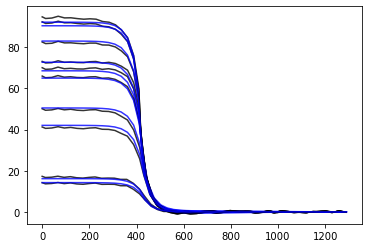

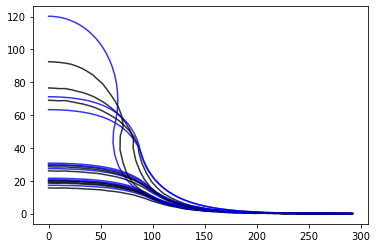

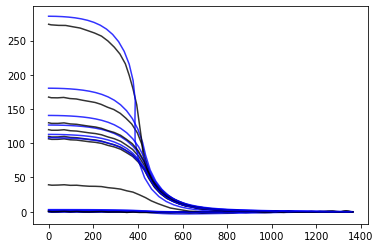

In [12]:
val_omegas = validation.where(validation.omega == 1).dropna(how = 'all')[0:40]
for i in set(val_omegas.Param_id):
    val_sub = validation.where(validation.Param_id == i).dropna(how = 'all')
    for count in sample(set(np.arange(0,len(val_sub))), 10):
        plt.plot(model.predict(val_sub[features])[count,0:50], model.predict(val_sub[features])[count,50:], label = 'prediction', c = 'black', alpha = .8)
        plt.plot(val_sub.iloc[count, -104:-54], val_sub.iloc[count, -54:-4], label = 'actual', c = 'blue', alpha = .8)
        
    plt.show()

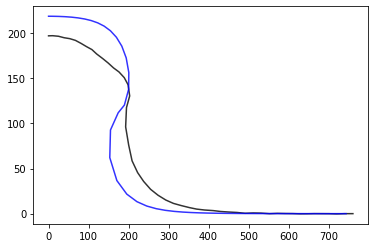

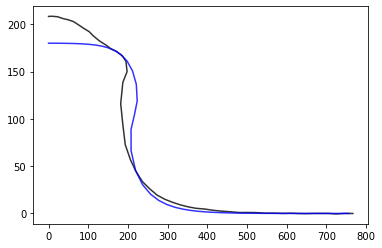

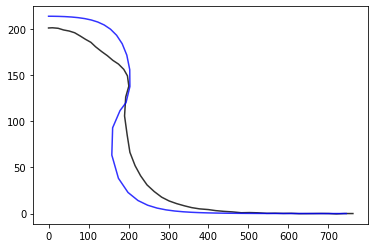

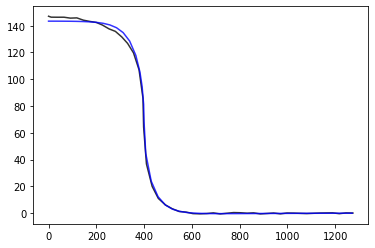

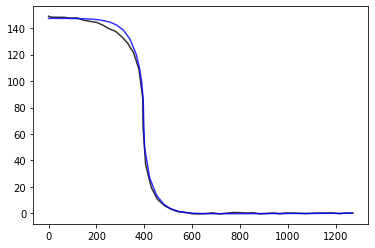

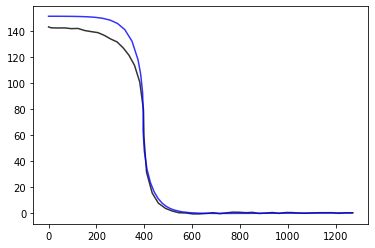

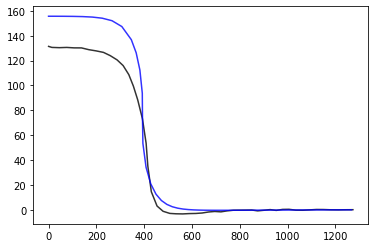

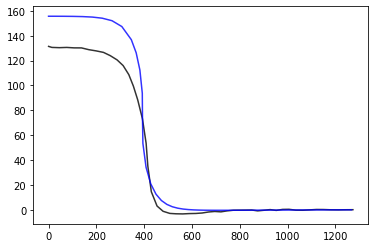

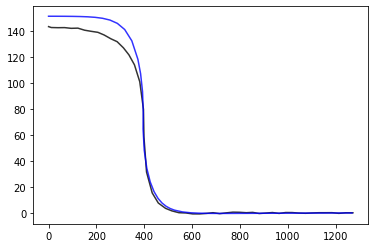

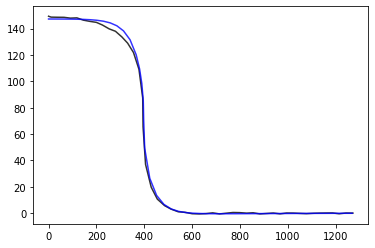

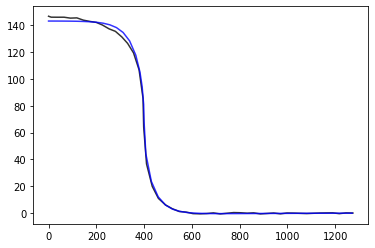

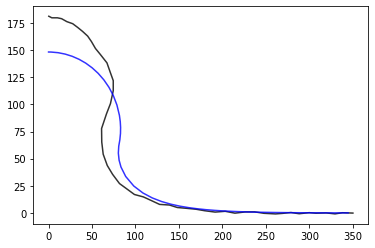

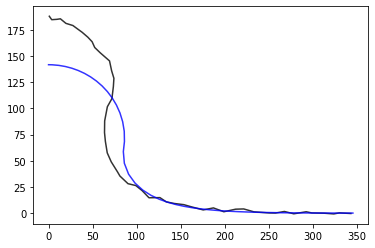

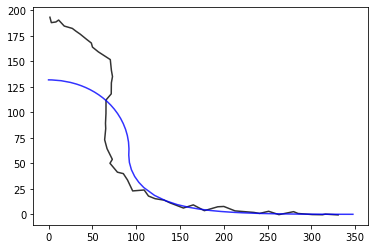

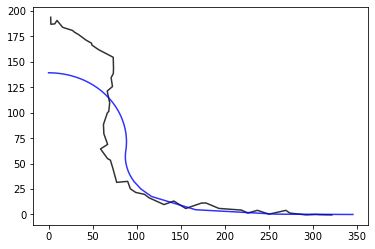

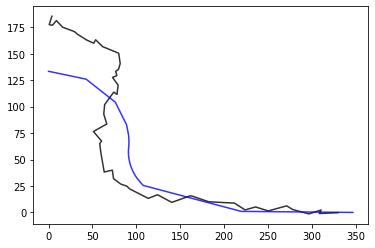

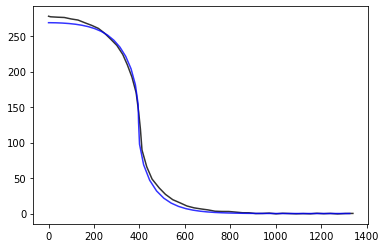

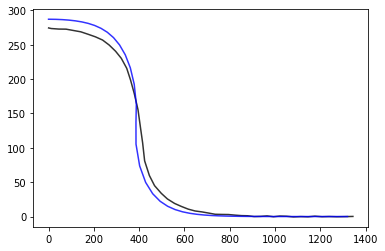

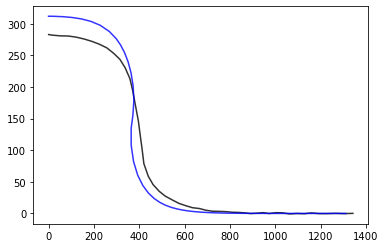

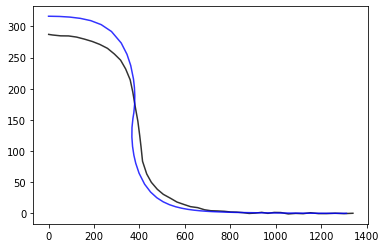

In [13]:
val_omegas = validation.where(validation.omega == 1).dropna(how = 'all')
#for i in set(val_omegas.index):
val_sub = validation.loc[set(val_omegas.index)]


for i in np.arange(0,20):
    plt.plot(model.predict(val_sub[features])[i,0:50], model.predict(val_sub[features])[i,50:100], label = 'prediction', c = 'black', alpha = .8)
    plt.plot(val_sub.iloc[i, -104:-54], val_sub.iloc[i, -54:-4], label = 'actual', c = 'blue', alpha = .8)
    plt.show()
